In [1]:
import pystac_client
import os
import boto3
from obstore.store import S3Store
from obstore.auth.boto3 import Boto3CredentialProvider
from virtualizarr.registry import ObjectStoreRegistry
from obstore.store import S3Store
from virtualizarr import open_virtual_dataset
from virtual_tiff import VirtualTIFF
import xarray as xr
import pyproj
import xproj
import rasterix
import logging
import morecantile
import shapely
from shapely.ops import transform
from pyproj import Transformer
from shapely import wkt
from shapely.geometry import box
import pystac
from rasterio.warp import transform_bounds
from affine import Affine
from rasterix import RasterIndex
from pyresample.area_config import create_area_def
from rasterio.transform import array_bounds
from pyresample.gradient import block_nn_interpolator, gradient_resampler_indices_block
from pyresample.resampler import resample_blocks
import folium

#### Select a Landsat granule from the Earth-Search STAC API

In [2]:
catalog = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")

california_bbox = [-124.4096, 32.5343, -114.1312, 42.0095]

search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=california_bbox,
    datetime="2025-10-01/2025-10-10",
    max_items=10
)

items = list(search.items())
item = items[4]
item

<Item id=LC09_L2SP_038038_20251008_02_T1>

#### Generate Zarr Convention geo-proj metadata.

In [3]:
def generate_geoproj(item: pystac.Item):
    projected_bbox = transform_bounds(
        "EPSG:4326",
        item.properties["proj:code"],
        *item.bbox
    )
    geo_proj_extension = {
        "version": "0.1.0",
        "schema": "https://raw.githubusercontent.com/zarr-experimental/geo-proj/refs/tags/v0.1.0/schema.json",
        "name": "geo:proj",
        "description": "Coordinate reference system information for geospatial data",
        "spec": "https://github.com/zarr-experimental/geo-proj/blob/v0.1.0/README.md",
        "configuration": {
            "code": item.properties["proj:code"],
            "spatial_dimensions": ["y", "x"],
            "transform": item.properties["proj:transform"],
            "shape": item.properties["proj:shape"],
            "bbox": projected_bbox,
        }
    }
    return geo_proj_extension

In [4]:
geo_proj = generate_geoproj(item=item)
geo_proj

{'version': '0.1.0',
 'schema': 'https://raw.githubusercontent.com/zarr-experimental/geo-proj/refs/tags/v0.1.0/schema.json',
 'name': 'geo:proj',
 'description': 'Coordinate reference system information for geospatial data',
 'spec': 'https://github.com/zarr-experimental/geo-proj/blob/v0.1.0/README.md',
 'configuration': {'code': 'EPSG:32611',
  'spatial_dimensions': ['y', 'x'],
  'transform': [30, 0, 624885, 0, -30, 3629415],
  'shape': [7691, 7561],
  'bbox': (622293.8957757186,
   3393824.01985196,
   859355.6098106557,
   3634759.398491474)}}

#### Set protocol, bucket and AWS profile values for use in obstore and virtualizarr registry

In [5]:
scheme = "s3://"
bucket = "usgs-landsat"
region = "us-west-2"

In [6]:
profile = "impactnew"
os.environ["AWS_PROFILE"] = profile

In [7]:
session = boto3.Session()
object_store = S3Store(
    bucket=bucket,
    region=region,
    request_payer=True,
    credential_provider=Boto3CredentialProvider(session=session),
)
registry = ObjectStoreRegistry({f"{scheme}{bucket}": object_store})

#### Use the VirtualTIFF virtualizarr parser to create a virtualizarr manifest zarr store for the red band at the highest overview.

In [8]:
asset = item.assets["red"]
parser=VirtualTIFF(ifd=0)
manifest_store = parser(url=asset.href, registry=registry)
ds = xr.open_dataset(manifest_store, engine="zarr", consolidated=False, zarr_format=3)
ds

/Users/seanharkins/projects/zarr-datafusion-examples/.venv/lib/python3.13/site-packages/numcodecs/zarr3.py:164: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/Users/seanharkins/projects/zarr-datafusion-examples/.venv/lib/python3.13/site-packages/zarr/codecs/numcodecs/_codecs.py:139: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


<xarray.Dataset> Size: 116MB
Dimensions:  (y: 7691, x: 7561)
Dimensions without coordinates: y, x
Data variables:
    0        (y, x) uint16 116MB ...

#### Use the geo-proj convention metadata to create an affine transformation and set a rasterix RasterIndex to use for selection operations.

In [9]:
affine = Affine(*geo_proj["configuration"]["transform"])
index = RasterIndex.from_transform(
    affine=affine,
    width=geo_proj["configuration"]["shape"][1],
    height=geo_proj["configuration"]["shape"][0],
    x_dim="x",
    y_dim="y",
    crs=geo_proj["configuration"]["code"],
)
coords = xr.Coordinates.from_xindex(index)
ds = ds.assign_coords(coords)
ds

<xarray.Dataset> Size: 116MB
Dimensions:  (y: 7691, x: 7561)
Coordinates:
  * y        (y) float64 62kB 3.629e+06 3.629e+06 ... 3.399e+06 3.399e+06
  * x        (x) float64 60kB 6.249e+05 6.249e+05 ... 8.517e+05 8.517e+05
Data variables:
    0        (y, x) uint16 116MB ...
Indexes:
  ┌ x        RasterIndex (crs=EPSG:32611)
  └ y

#### Use the geo-proj convention metadata to assign the appropriate CRS via xproj.

In [10]:
ds = ds.proj.assign_crs(spatial_ref=geo_proj["configuration"]["code"], allow_override=True)
ds

<xarray.Dataset> Size: 116MB
Dimensions:      (y: 7691, x: 7561)
Coordinates:
  * y            (y) float64 62kB 3.629e+06 3.629e+06 ... 3.399e+06 3.399e+06
  * x            (x) float64 60kB 6.249e+05 6.249e+05 ... 8.517e+05 8.517e+05
  * spatial_ref  int64 8B 0
Data variables:
    0            (y, x) uint16 116MB ...
Indexes:
  ┌ x            RasterIndex (crs=EPSG:32611)
  └ y
    spatial_ref  CRSIndex (crs=EPSG:32611)

#### Get the list of web merctaor tiles intersecting the granule.

In [11]:
granule_bbox = morecantile.commons.BoundingBox(*item.bbox)
tms = morecantile.tms.get("WebMercatorQuad")
tiles = list(tms.tiles(*granule_bbox, zooms=12))

#### Select one of the intersecting tiles and reproject its bounds to the granule's CRS.

In [12]:
tile_bbox = tms.xy_bounds(tiles[700])
tile_bbox_geom = shapely.geometry.box(*tile_bbox)
utm_transformer = Transformer.from_crs("EPSG:3857", item.properties["proj:code"], always_xy=True).transform
tile_bbox_utm = transform(utm_transformer, tile_bbox_geom)
tile_bbox_utm.bounds

(652633.3340567892, 3428218.1529057985, 661147.6439239838, 3436691.743682587)

#### We can use this reprojected tile bbox for CRS aware selection operations in xarray with rasterix.

In [13]:
left, bottom, right, top = tile_bbox_utm.bounds
ds_tile = ds.sel(x=slice(left, right), y=slice(top, bottom))
ds_tile

<xarray.Dataset> Size: 165kB
Dimensions:      (y: 282, x: 284)
Coordinates:
  * y            (y) float64 2kB 3.437e+06 3.437e+06 ... 3.428e+06 3.428e+06
  * x            (x) float64 2kB 6.526e+05 6.526e+05 ... 6.611e+05 6.611e+05
  * spatial_ref  int64 8B 0
Data variables:
    0            (y, x) uint16 160kB ...
Indexes:
  ┌ x            RasterIndex (crs=EPSG:32611)
  └ y
    spatial_ref  CRSIndex (crs=EPSG:32611)

#### For context, display a map to visualize the web mercator tiles that intersect the granule.

In [14]:
zoom_bbox = box(*item.bbox)
zoom_bbox.centroid
m = folium.Map(
    location=[zoom_bbox.centroid.y, zoom_bbox.centroid.x],
    zoom_start=8,
    tiles="CartoDB positron",
    width="50%",
)
folium.Rectangle(
    bounds=[
        [item.bbox[1], item.bbox[0]],  # [south, west]
        [item.bbox[3], item.bbox[2]]   # [north, east]
    ],
    color="red",
    fill=True,
    fillOpacity=0.1,
    weight=2,
).add_to(m)
for tile in tiles:
    tile_bounds = tms.bounds(tile)
    
    folium.Rectangle(
        bounds=[
            [tile_bounds.bottom, tile_bounds.left],   # southwest
            [tile_bounds.top, tile_bounds.right]      # northeast
        ],
        color='blue',
        fill=True,
        fillOpacity=0.1,
        weight=2,
        popup=f"Tile: {tile.z}/{tile.x}/{tile.y}"
    ).add_to(m)
m

#### Using the geo-proj metadata configure a pyresample source area definition for granule and a target area definition for the selected tile.

In [15]:
tile_shape = 256
height, width = geo_proj["configuration"]["shape"]
left, bottom, right, top = array_bounds(height, width, affine)
target_area_def = create_area_def(
    area_id=1,
    projection="EPSG:3857",
    shape=(tile_shape, tile_shape),
    area_extent=tile_bbox_geom.bounds
)

source_area_def = create_area_def(
    area_id=2,
    projection=geo_proj["configuration"]["code"],
    shape=(geo_proj["configuration"]["shape"][0], geo_proj["configuration"]["shape"][1]),
    area_extent=geo_proj["configuration"]["bbox"],
)

#### Set the dataarray chunking to reflect the web optimized profile used by the Landsat COGs.
#### Use pyresample to resample blockwise from the granule's CRS to web mercator.

In [18]:
da = ds["0"].chunk({"y": tile_shape, "x": tile_shape})
indices_xy = resample_blocks(
    gradient_resampler_indices_block,
    source_area_def,
    [],
    target_area_def,
    chunk_size=(1, tile_shape, tile_shape),
    dtype=float,
)
resampled = resample_blocks(
    block_nn_interpolator,
    source_area_def,
    [da.data],
    target_area_def,
    dst_arrays=[indices_xy],
    chunk_size=(1, tile_shape, tile_shape),
    dtype=ds["0"].dtype,
)
projected_tile = resampled.compute()

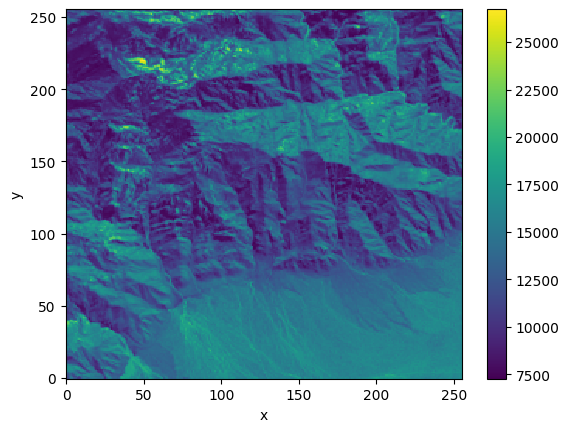

In [21]:
wmts_tile = xr.DataArray(projected_tile, dims=("y", "x"))
wmts_tile.plot()

#### Use the tile's WGS84 bounds to add the Numpy data to Folium.


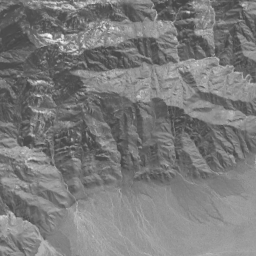

In [22]:
wgs84_transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True).transform
tile_bbox_wgs84 = transform(wgs84_transformer, tile_bbox_geom)
west, south, east, north = tile_bbox_wgs84.bounds
bounds = [[south, west], [north, east]]
folium.raster_layers.ImageOverlay(
    image=wmts_tile.data,
    bounds=bounds,
    colormap=lambda x: (x, x, x, 1),
    origin="lower"
).add_to(m)
m.fit_bounds(bounds)
m